In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
import time
import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

# API
from nats_bench import create

# custom modules
from custom.tss_model import TinyNetwork
from xautodl.models.cell_searchs.genotypes import Structure
from ZeroShotProxy import *

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2024-01-24 12:18:50.144266: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-24 12:18:50.189888: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 12:18:50.903378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
parser = argparse.ArgumentParser("Training-free NAS on NAS-Bench-201 (NATS-Bench-TSS)")
parser.add_argument("--data_path", type=str, default='./cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space", type=str, default='tss', help="The search space name.")
parser.add_argument("--config_path", type=str, default='./configs/nas-benchmark/algos/weight-sharing.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
parser.add_argument("--affine", type=int, default=1, choices=[0, 1], help="Whether use affine=True or False in the BN layer.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")

# log
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")

# custom
parser.add_argument("--gpu", type=int, default=0, help="")
parser.add_argument("--workers", type=int, default=4, help="number of data loading workers")
parser.add_argument("--api_data_path", type=str, default="./api_data/NATS-tss-v1_0-3ffb9-simple/", help="")
parser.add_argument("--save_dir", type=str, default='./results/tmp', help="Folder to save checkpoints and log.")
parser.add_argument('--zero_shot_score', type=str, default='az_nas', choices=['az_nas','zico','zen','gradnorm','naswot','synflow','snip','grasp','te_nas','gradsign'])
parser.add_argument("--rand_seed", type=int, default=1, help="manual seed (we use 1-to-5)")
args = parser.parse_args(args=[])

if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

print(args.rand_seed)
print(args)
xargs=args

1
Namespace(data_path='./cifar.python', dataset='cifar10', search_space='tss', config_path='./configs/nas-benchmark/algos/weight-sharing.config', max_nodes=4, channel=16, num_cells=5, affine=1, track_running_stats=0, print_freq=200, gpu=0, workers=4, api_data_path='./api_data/NATS-tss-v1_0-3ffb9-simple/', save_dir='./results/tmp', zero_shot_score='az_nas', rand_seed=1)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=results/tmp, use-tf=False, writer=None)
Arguments : -------------------------------
data_path        : ./cifar.python
dataset          : cifar10
search_space     : tss
config_path      : ./configs/nas-benchmark/algos/weight-sharing.config
max_nodes        : 4
channel          : 16
num_cells        : 5
affine           : 1
track_running_stats : 0
print_freq       : 200
gpu              : 0
workers          : 4
api_data_path    : ./api_data/NATS-tss-v1_0-3ffb9-simple/
save_dir         : ./results/tmp
zero_shot_score  : az_nas
rand_seed        : 1
Python  Version  : 3.10.11 (main, Apr 20 2023, 19:02:41) [GCC 11.2.0]
Pillow  Version  : 9.4.0
PyTorch Version  : 2.0.1
cuDNN   Version  : 8500
CUDA available   : True
CUDA GPU numbers : 1
CUDA_VISIBLE_DEVICES : 0


In [4]:
## API
api = create(xargs.api_data_path, xargs.search_space, fast_mode=True, verbose=False)
logger.log("Create API = {:} done".format(api))

## data
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, train_loader, valid_loader = get_nas_search_loaders(train_data,
                                                                   valid_data,
                                                                   xargs.dataset,
                                                                   "./configs/nas-benchmark/",
                                                                   (config.batch_size, config.test_batch_size),
                                                                   xargs.workers,)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

## model
search_space = get_search_spaces(xargs.search_space, "nats-bench")
logger.log("search space : {:}".format(search_space))

device = torch.device('cuda:{}'.format(xargs.gpu))

Create API = NATStopology(0/15625 architectures, fast_mode=True, file=) done
Files already downloaded and verified
Files already downloaded and verified
./configs/nas-benchmark/algos/weight-sharing.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=100, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=100, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
search space : ['none', 'skip_connect', 'nor_conv_1x1', 'nor_conv_3x3', 'avg_pool_3x3']


In [5]:
def random_genotype(max_nodes, op_names):
    genotypes = []
    for i in range(1, max_nodes):
        xlist = []
        for j in range(i):
            node_str = "{:}<-{:}".format(i, j)
            op_name = random.choice(op_names)
            xlist.append((op_name, j))
        genotypes.append(tuple(xlist))
    arch = Structure(genotypes)
    return arch

real_input_metrics = ['zico', 'snip', 'grasp', 'te_nas', 'gradsign']
    
def search_find_best(xargs, xloader, n_samples = None, archs = None):
    logger.log("Searching with {}".format(xargs.zero_shot_score.lower()))
    score_fn_name = "compute_{}_score".format(xargs.zero_shot_score.lower())
    score_fn = globals().get(score_fn_name)
    input_, target_ = next(iter(xloader))
    resolution = input_.size(2)
    batch_size = input_.size(0)
    zero_shot_score_dict = None
    arch_list = []
    if xargs.zero_shot_score.lower() in real_input_metrics:
        print('Use real images as inputs')
        trainloader = train_loader
    else:
        print('Use random inputs')
        trainloader = None
        
    if archs is None and n_samples is not None:
        all_time = []
        all_mem = []
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        for i in tqdm.tqdm(range(n_samples)):
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
            # random sampling
            arch = random_genotype(xargs.max_nodes, search_space)
            network = TinyNetwork(xargs.channel, xargs.num_cells, arch, class_num)
            network = network.to(device)
            network.train()

            start.record()
            

            info_dict = score_fn.compute_nas_score(network, gpu=xargs.gpu, trainloader=trainloader, resolution=resolution, batch_size=batch_size)

            end.record()
            torch.cuda.synchronize()
            all_time.append(start.elapsed_time(end))
#             all_mem.append(torch.cuda.max_memory_reserved())
            all_mem.append(torch.cuda.max_memory_allocated())

            arch_list.append(arch)
            if zero_shot_score_dict is None: # initialize dict
                zero_shot_score_dict = dict()
                for k in info_dict.keys():
                    zero_shot_score_dict[k] = []
            for k, v in info_dict.items():
                zero_shot_score_dict[k].append(v)

        logger.log("------Runtime------")
        logger.log("All: {:.5f} ms".format(np.mean(all_time)))
        logger.log("------Avg Mem------")
        logger.log("All: {:.5f} GB".format(np.mean(all_mem)/1e9))
        logger.log("------Max Mem------")
        logger.log("All: {:.5f} GB".format(np.max(all_mem)/1e9))
        
    elif archs is not None and n_samples is None:
        all_time = []
        all_mem = []
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        for arch in tqdm.tqdm(archs):
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
            network = TinyNetwork(xargs.channel, xargs.num_cells, arch, class_num)
            network = network.to(device)
            network.train()

            start.record()
            

            info_dict = score_fn.compute_nas_score(network, gpu=xargs.gpu, trainloader=trainloader, resolution=resolution, batch_size=batch_size)

            end.record()
            torch.cuda.synchronize()
            all_time.append(start.elapsed_time(end))
#             all_mem.append(torch.cuda.max_memory_reserved())
            all_mem.append(torch.cuda.max_memory_allocated())

            arch_list.append(arch)
            if zero_shot_score_dict is None: # initialize dict
                zero_shot_score_dict = dict()
                for k in info_dict.keys():
                    zero_shot_score_dict[k] = []
            for k, v in info_dict.items():
                zero_shot_score_dict[k].append(v)

        logger.log("------Runtime------")
        logger.log("All: {:.5f} ms".format(np.mean(all_time)))
        logger.log("------Avg Mem------")
        logger.log("All: {:.5f} GB".format(np.mean(all_mem)/1e9))
        logger.log("------Max Mem------")
        logger.log("All: {:.5f} GB".format(np.max(all_mem)/1e9))
        
    return arch_list, zero_shot_score_dict

In [6]:
# ######### search across random N archs #########
# archs, results = search_find_best(xargs, train_loader, n_samples=3000)

# ######### search across N archs uniformly sampled according to test acc. #########
# def uniform_sample_archs(search_space, xargs, api, n_samples=1000, dataset='ImageNet16-120'):
#     arch = random_genotype(xargs.max_nodes, search_space)
#     search_space = get_search_spaces(xargs.search_space, "nats-bench")
#     archs = arch.gen_all(search_space, xargs.max_nodes, False)
    
#     def get_results_from_api(api, arch, dataset='cifar10'):
#         dataset_candidates = ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120']
#         assert dataset in dataset_candidates
#         index = api.query_index_by_arch(arch)
#         api._prepare_info(index)
#         archresult = api.arch2infos_dict[index]['200']
#         if dataset == 'cifar10-valid':
#             acc = archresult.get_metrics(dataset, 'x-valid', iepoch=None, is_random=False)['accuracy']
#         elif dataset == 'cifar10':
#             acc = archresult.get_metrics(dataset, 'ori-test', iepoch=None, is_random=False)['accuracy']
#         else:
#             acc = archresult.get_metrics(dataset, 'x-test', iepoch=None, is_random=False)['accuracy']
#         return acc

#     accs = []
#     for a in archs:
#         accs.append(get_results_from_api(api, a, dataset))
#     interval = len(archs) // n_samples
#     sorted_indices = np.argsort(accs)
#     new_archs = []
#     for i, idx in enumerate(sorted_indices):
#         if i % interval == 0:
#             new_archs.append(archs[idx])
#     archs = new_archs
    
#     return archs

# if os.path.exists("./tss_uniform_arch.pickle"):
#     with open("./tss_uniform_arch.pickle", "rb") as fp:
#         uniform_archs = pickle.load(fp)
# else:
#     uniform_archs = uniform_sample_archs(search_space, xargs, api, 1000, 'ImageNet16-120')
#     with open("./tss_uniform_arch.pickle", "wb") as fp:
#         pickle.dump(uniform_archs, fp)
        
# result_path = "./{}_uniform_arch.pickle".format(args.zero_shot_score)
# if os.path.exists(result_path):
#     print("results already exists")
#     with open(result_path, "rb") as fp:
#         results = pickle.load(fp)
#     archs = uniform_archs
# else:
#     archs, results = search_find_best(xargs, train_loader, archs=uniform_archs)
#     with open(result_path, "wb") as fp:
#         pickle.dump(results, fp)


######### search across all archs #########
def generate_all_archs(search_space, xargs):
    arch = random_genotype(xargs.max_nodes, search_space)
    archs = arch.gen_all(search_space, xargs.max_nodes, False)
    return archs

if os.path.exists("./tss_all_arch.pickle"):
    with open("./tss_all_arch.pickle", "rb") as fp:
        all_archs = pickle.load(fp)
else:
    all_archs = generate_all_archs(search_space, xargs)
    with open("./tss_all_arch.pickle", "wb") as fp:
        pickle.dump(all_archs, fp)

# archs, results = search_find_best(xargs, train_loader, archs=all_archs)

####
result_path = "./{}_all_arch.pickle".format(args.zero_shot_score)
if os.path.exists(result_path):
    print("results already exists")
    with open(result_path, "rb") as fp:
        results = pickle.load(fp)
    archs = all_archs
else:
    archs, results = search_find_best(xargs, train_loader, archs=all_archs)
    with open(result_path, "wb") as fp:
        pickle.dump(results, fp)

results already exists


In [7]:
def get_results_from_api(api, arch, dataset='cifar10'):
    dataset_candidates = ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120']
    assert dataset in dataset_candidates
    index = api.query_index_by_arch(arch)
    api._prepare_info(index)
    archresult = api.arch2infos_dict[index]['200']
    
    if dataset == 'cifar10-valid':
        acc = archresult.get_metrics(dataset, 'x-valid', iepoch=None, is_random=False)['accuracy']
    elif dataset == 'cifar10':
        acc = archresult.get_metrics(dataset, 'ori-test', iepoch=None, is_random=False)['accuracy']
    else:
        acc = archresult.get_metrics(dataset, 'x-test', iepoch=None, is_random=False)['accuracy']
    flops = archresult.get_compute_costs(dataset)['flops']
    params = archresult.get_compute_costs(dataset)['params']
    
    return acc, flops, params

api_valid_accs, api_flops, api_params = [], [], []
for a in archs:
    valid_acc, flops, params = get_results_from_api(api, a, 'cifar10')
#     valid_acc, flops, params = get_results_from_api(api, a, 'cifar100')
#     valid_acc, flops, params = get_results_from_api(api, a, 'ImageNet16-120')
    api_valid_accs.append(valid_acc)
    api_flops.append(flops)
    api_params.append(params)
    
print("Maximum acc: {}% \n Info".format(np.max(api_valid_accs)))
best_idx = np.argmax(api_valid_accs)
best_arch = archs[best_idx]
if api is not None:
    print("{:}".format(api.query_by_arch(best_arch, "200")))

Maximum acc: 94.37333333333333% 
 Info
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_1x1~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=13714
cifar10-valid  FLOP=153.27 M, Params=1.073 MB, latency=20.34 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.99%], valid : [loss = 0.430 & top1 = 91.50%]
cifar10        FLOP=153.27 M, Params=1.073 MB, latency=20.34 ms.
cifar10        train : [loss = 0.002 & top1 = 99.99%], test  : [loss = 0.272 & top1 = 94.37%]
cifar100       FLOP=153.28 M, Params=1.079 MB, latency=22.68 ms.
cifar100       train : [loss = 0.016 & top1 = 99.90%], valid : [loss = 1.283 & top1 = 73.31%], test : [loss = 1.282 & top1 = 73.09%]
ImageNet16-120 FLOP= 38.33 M, Params=1.081 MB, latency=18.75 ms.
ImageNet16-120 train : [loss = 1.064 & top1 = 70.31%], valid : [loss = 2.258 & top1 = 45.59%], test : [loss = 2.283 & top1 = 46.33%]


expressivity
progressivity
trainability
|skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=3558
cifar10-valid  FLOP=121.82 M, Params=0.858 MB, latency=21.29 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.494 & top1 = 90.09%]
cifar10        FLOP=121.82 M, Params=0.858 MB, latency=21.29 ms.
cifar10        train : [loss = 0.003 & top1 = 99.96%], test  : [loss = 0.298 & top1 = 93.63%]
cifar100       FLOP=121.82 M, Params=0.864 MB, latency=20.30 ms.
cifar100       train : [loss = 0.062 & top1 = 99.20%], valid : [loss = 1.288 & top1 = 70.54%], test : [loss = 1.281 & top1 = 70.60%]
ImageNet16-120 FLOP= 30.46 M, Params=0.866 MB, latency=19.05 ms.
ImageNet16-120 train : [loss = 1.568 & top1 = 57.66%], valid : [loss = 2.161 & top1 = 44.83%], test : [loss = 2.153 & top1 = 45.30%]
AZ-NAS: 0.7408773022062063	0.91271449672946	0.9127

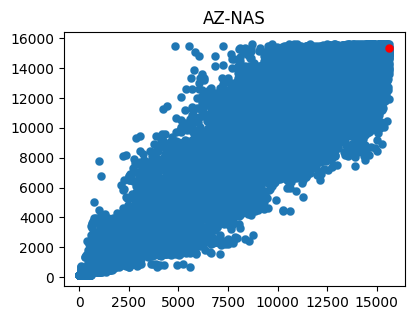

In [8]:
fig_scale = 1.1

if xargs.zero_shot_score.lower() == 'az_nas':
    rank_agg = None
    l = len(api_flops)
    rank_agg = np.log(stats.rankdata(api_flops) / l)
    for k in results.keys():
        print(k)
        if rank_agg is None:
            rank_agg = np.log( stats.rankdata(results[k]) / l)
        else:
            rank_agg = rank_agg + np.log( stats.rankdata(results[k]) / l)


    best_idx = np.argmax(rank_agg)

    best_arch, acc = archs[best_idx], api_valid_accs[best_idx]
    if api is not None:
        print("{:}".format(api.query_by_arch(best_arch, "200")))


    x = stats.rankdata(rank_agg)
    y = stats.rankdata(api_valid_accs)
    kendalltau = stats.kendalltau(x, y)
    spearmanr = stats.spearmanr(x, y)
    pearsonr = stats.pearsonr(x, y)
    print("AZ-NAS: {}\t{}\t{}\t".format(kendalltau[0], pearsonr[0], spearmanr[0]))
    plt.figure(figsize=(4*fig_scale,3*fig_scale))
    plt.scatter(x, y, linewidths=0.1)
    best_idx = np.argmax(rank_agg)
    plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=0.1)
    plt.title("AZ-NAS")
    plt.show()
    
elif xargs.zero_shot_score.lower() == 'te_nas':
    rank_agg = None
    for k in results.keys():
        print(k)
        if rank_agg is None:
            rank_agg = stats.rankdata(results[k])
        else:
            rank_agg = rank_agg + stats.rankdata(results[k])


    best_idx = np.argmax(rank_agg)

    best_arch, acc = archs[best_idx], api_valid_accs[best_idx]
    if api is not None:
        print("{:}".format(api.query_by_arch(best_arch, "200")))


    x = stats.rankdata(rank_agg)
    y = stats.rankdata(api_valid_accs)
    kendalltau = stats.kendalltau(x, y)
    spearmanr = stats.spearmanr(x, y)
    pearsonr = stats.pearsonr(x, y)
    print("TE-NAS: {}\t{}\t{}\t".format(kendalltau[0], pearsonr[0], spearmanr[0]))
    plt.figure(figsize=(4*fig_scale,3*fig_scale))
    plt.scatter(x, y, linewidths=0.1)
    best_idx = np.argmax(rank_agg)
    plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=0.1)
    plt.title("TE-NAS")
    plt.show()

else:
    for k, v in results.items():
        print(k)
        best_idx = np.argmax(v)

        best_arch, acc = archs[best_idx], api_valid_accs[best_idx]
        if api is not None:
            print("{:}".format(api.query_by_arch(best_arch, "200")))

        x = stats.rankdata(v)
        y = stats.rankdata(api_valid_accs)
        kendalltau = stats.kendalltau(x, y)
        spearmanr = stats.spearmanr(x, y)
        pearsonr = stats.pearsonr(x, y)
        print("{}: {}\t{}\t{}\t".format(k, kendalltau[0], pearsonr[0], spearmanr[0]))
        plt.figure(figsize=(4*fig_scale,3*fig_scale))
        plt.scatter(x, y, linewidths=0.1)
        best_idx = np.argmax(v)
        plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=0.1)
        plt.title("{}".format(k))
        plt.show()

In [9]:
# ### Confusion matrix

# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt
# import copy

# metrics = copy.deepcopy(results)

# metrics['accuracy'] = api_valid_accs
# metrics['complexity'] = api_flops

# # keys = ['accuracy', 'expressivity', 'progressivity', 'trainability', 'complexity']
# # key_names = ['Acc.', r"$s^{\mathcal{E}}$", r"$s^{\mathcal{P}}$", r"$s^{\mathcal{T}}$", r"$s^{\mathcal{C}}$"]
# keys = ['expressivity', 'progressivity', 'trainability', 'complexity']
# key_names = [r"$s^{\mathcal{E}}$", r"$s^{\mathcal{P}}$", r"$s^{\mathcal{T}}$", r"$s^{\mathcal{C}}$"]
# print(keys)

# matrix = np.zeros((len(keys),len(keys)))

# for i in range(len(keys)):
#     for j in range(len(keys)):
#         x = stats.rankdata(metrics[keys[i]])
#         y = stats.rankdata(metrics[keys[j]])
#         kendalltau = stats.kendalltau(x, y)[0]
#         matrix[i,j] = kendalltau

# print(matrix)
        
# df_cm = pd.DataFrame(matrix, index = [i for i in key_names], columns = [i for i in key_names])
# plt.figure(figsize=(6,3))
# sn.set(font_scale=1.9) # for label size
# ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 17}, cmap='GnBu', fmt='.2f') # font size
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=16)
# plt.yticks(rotation=0) 
# plt.savefig('confusion_matrix.pdf', bbox_inches = 'tight', pad_inches = 0)
# plt.show()

In [10]:
# #### Visualize scatter plots
# def visualize_proxy_cmap(x, y, title, save_name, ref_rank=None):
#     if ref_rank is None:
#         ref_rank = x
#     plt.figure(figsize=(4.5*1.5,3*1.5))
#     plt.grid(True, alpha=0.3)
#     plt.scatter(x,y, linewidths=0.1, c=ref_rank, cmap='viridis_r')
#     plt.xlabel("Predicted network ranking", fontsize=16)
#     plt.ylabel("Ground-truth network ranking", fontsize=16)
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.colorbar()
#     plt.title(title, fontsize=20)
# #     plt.savefig('{}.pdf'.format(save_name), bbox_inches = 'tight', pad_inches = 0)
#     plt.show()
    
# def visualize_proxy(x, y, title, save_name):
#     plt.figure(figsize=(3.8*1.5,3*1.5))
#     plt.grid(True, alpha=0.3)
#     plt.scatter(x,y, linewidths=0.1, c="#140c86")
#     plt.xlabel("Predicted network ranking", fontsize=16)
#     plt.ylabel("Ground-truth network ranking", fontsize=16)
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.title(title, fontsize=20)
# #     plt.savefig('{}.pdf'.format(save_name), bbox_inches = 'tight', pad_inches = 0)
#     plt.show()

# if xargs.zero_shot_score.lower() == 'az_nas':
#     rank_agg = None
#     l = len(api_flops)
#     rank_agg = np.log(stats.rankdata(api_flops) / l)
#     for k in results.keys():
#         print(k)
#         if rank_agg is None:
#             rank_agg = np.log( stats.rankdata(results[k]) / l)
#         else:
#             rank_agg = rank_agg + np.log( stats.rankdata(results[k]) / l)


#     best_idx = np.argmax(rank_agg)

#     best_arch, acc = archs[best_idx], api_valid_accs[best_idx]
#     if api is not None:
#         print("{:}".format(api.query_by_arch(best_arch, "200")))


#     x = stats.rankdata(rank_agg)
#     x_agg = x
#     y = stats.rankdata(api_valid_accs)
#     kendalltau = stats.kendalltau(x, y)
#     spearmanr = stats.spearmanr(x, y)
#     pearsonr = stats.pearsonr(x, y)
#     visualize_proxy(x,y,r"AZ-NAS ($\tau$={0:.3f}, $\rho$={1:.3f})".format(kendalltau[0], spearmanr[0]), 'AZ-NAS_comp')
#     visualize_proxy_cmap(x,y,r"AZ-NAS ($\tau$={0:.3f}, $\rho$={1:.3f})".format(kendalltau[0], spearmanr[0]), 'AZ-NAS')
    
#     metrics = {'FLOPs':api_flops}
#     for k, v in results.items():
#         metrics[k] = v

#         print(k)
#         best_idx = np.argmax(v)

#         best_arch, acc = archs[best_idx], api_valid_accs[best_idx]
#         if api is not None:
#             print("{:}".format(api.query_by_arch(best_arch, "200")))

#     title_names = {"expressivity":"Expressivity","progressivity":"Progressivity","trainability":"Trainability","FLOPs":"Complexity"}
#     for k in metrics.keys():
#         x = stats.rankdata(metrics[k])
#         y = stats.rankdata(api_valid_accs)
#         kendalltau = stats.kendalltau(x, y)
#         spearmanr = stats.spearmanr(x, y)
#         pearsonr = stats.pearsonr(x, y)
#         visualize_proxy_cmap(x,y,r"{0} ($\tau$={1:.3f}, $\rho$={2:.3f})".format(title_names[k],kendalltau[0], spearmanr[0]),title_names[k],x_agg)
        
# elif xargs.zero_shot_score.lower() == 'te_nas':
#     title_names = {"te_nas":"TE-NAS"}
#     rank_agg = None
#     for k in results.keys():
#         print(k)
#         if rank_agg is None:
#             rank_agg = stats.rankdata(results[k])
#         else:
#             rank_agg = rank_agg + stats.rankdata(results[k])
#     x = stats.rankdata(rank_agg)
#     y = stats.rankdata(api_valid_accs)
#     kendalltau = stats.kendalltau(x, y)
#     spearmanr = stats.spearmanr(x, y)
#     pearsonr = stats.pearsonr(x, y)
#     visualize_proxy(x,y,r"{0} ($\tau$={1:.3f}, $\rho$={2:.3f})".format(title_names['te_nas'],kendalltau[0], spearmanr[0]),title_names['te_nas'])
        
# else:
#     title_names = {"zico":"ZiCo","zen":"ZenNAS",'params':"#Params",'naswot':"NASWOT","synflow":"Synflow","gradsign":"GradSign"}
#     for k in results.keys():
#         print(k)
#         x = stats.rankdata(results[k])
#         y = stats.rankdata(api_valid_accs)
#         kendalltau = stats.kendalltau(x, y)
#         spearmanr = stats.spearmanr(x, y)
#         pearsonr = stats.pearsonr(x, y)
#         visualize_proxy(x,y,r"{0} ($\tau$={1:.3f}, $\rho$={2:.3f})".format(title_names[k],kendalltau[0], spearmanr[0]),title_names[k])